In [5]:
##Segmentation on Sagemaker, using Pascal VOC

In [7]:
import sagemaker
sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = 'pascalvoc-segmentation'
s3_train_data = 's3://{}/{}/input/train'.format(bucket, prefix)
s3_validation_data = 's3://{}/{}/input/validation'.format(bucket, prefix)
s3_train_annotation_data = 's3://{}/{}/input/train_annotation'.format(bucket, prefix)
s3_validation_annotation_data = 's3://{}/{}/input/validation_annotation'.format(bucket, prefix)

In [8]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

In [9]:
from sagemaker.image_uris import retrieve
container = retrieve('semantic-segmentation', 'us-east-1')
container

'811284229777.dkr.ecr.us-east-1.amazonaws.com/semantic-segmentation:1'

In [11]:
seg = sagemaker.estimator.Estimator(
    container,
    sagemaker.get_execution_role(),
    instance_count=1,
    instance_type='ml.p3.2xlarge',
    output_path=s3_output_location
)

In [12]:
seg.set_hyperparameters(
    backbone='resnet-50',
    algorithm='fcn',
    use_pretrained_model=True,
    num_classes=21,
    num_training_samples=1464,
    epochs=30
)

In [13]:
from sagemaker import TrainingInput
train_data = TrainingInput(
    s3_train_data, 
    content_type='image/jpeg'
)
validation_data = TrainingInput(
    s3_validation_data,
    content_type='image/jpeg'
)
train_annotation = TrainingInput(
    s3_train_annotation_data,
    content_type='image/jpeg'
)

validation_annotation = TrainingInput(
    s3_validation_annotation_data,
    content_type='image/jpeg'
)

data_channels={
    'train': train_data,
    'validation': validation_data,
    'train_annotation': train_annotation,
    'validation_annotation': validation_annotation
}

In [14]:
seg.fit(inputs=data_channels)

2022-09-11 05:06:04 Starting - Starting the training job...
2022-09-11 05:06:31 Starting - Preparing the instances for trainingProfilerReport-1662872764: InProgress
............
2022-09-11 05:08:22 Downloading - Downloading input data.........
2022-09-11 05:10:03 Training - Downloading the training image........................
2022-09-11 05:14:04 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
[09/11/2022 05:13:58 INFO 139782539470656] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/default-input.json: {'backbone': 'resnet-50', 'algorithm': 'fcn', 'use_pretrained_model': 'True', 'crop_size': '240', 'epochs': '10', 'learning_rate': '0.001', 'optimizer': 'sgd', 'lr_scheduler': 'poly', 'lr_scheduler_factor': '0.1', 'weight_decay': '0.0001', 'momentum': '0.9', 'gamma1': '0.9', 'gamma2': '0.

In [15]:
seg_predictor = seg.deploy(
    initial_instance_count=1, 
    instance_type='ml.c5.2xlarge')

------------!

In [16]:
!wget -O test.jpg https://upload.wikimedia.org/wikipedia/commons/e/ea/SilverMorgan.jpg

--2022-09-11 06:25:29--  https://upload.wikimedia.org/wikipedia/commons/e/ea/SilverMorgan.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100288 (98K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  97.94K  --.-KB/s    in 0.05s   

2022-09-11 06:25:29 (1.83 MB/s) - ‘test.jpg’ saved [100288/100288]



In [28]:
import matplotlib.pyplot as plt
import PIL
filename = 'test.jpg'
im = PIL.Image.open(filename)
im.save(filename, "JPEG")

(-0.5, 336.5, 288.5, -0.5)

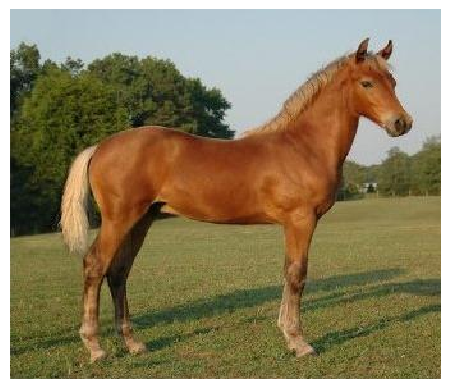

In [30]:
%matplotlib inline
plt.imshow(im)
plt.axis('off')

In [34]:
import boto3, json
import numpy as np

with open(filename, 'rb') as image:
    payload = image.read()
    payload = bytearray(payload)
client = boto3.client('sagemaker-runtime')
response = client.invoke_endpoint(
    EndpointName=seg_predictor.endpoint_name,
    ContentType='image/jpeg',
    Accept='image/png',
    Body=payload
)
response = response['Body'].read()

In [35]:
response

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01Q\x00\x00\x01!\x08\x03\x00\x00\x00\xf1\x8ac\xb1\x00\x00\x03\x00PLTE\x00\x00\x00\x01\x01\x01\x02\x02\x02\x03\x03\x03\x04\x04\x04\x05\x05\x05\x06\x06\x06\x07\x07\x07\x08\x08\x08\t\t\t\n\n\n\x0b\x0b\x0b\x0c\x0c\x0c\r\r\r\x0e\x0e\x0e\x0f\x0f\x0f\x10\x10\x10\x11\x11\x11\x12\x12\x12\x13\x13\x13\x14\x14\x14\x15\x15\x15\x16\x16\x16\x17\x17\x17\x18\x18\x18\x19\x19\x19\x1a\x1a\x1a\x1b\x1b\x1b\x1c\x1c\x1c\x1d\x1d\x1d\x1e\x1e\x1e\x1f\x1f\x1f   !!!"""###$$$%%%&&&\'\'\'((()))***+++,,,---...///000111222333444555666777888999:::;;;<<<===>>>???@@@AAABBBCCCDDDEEEFFFGGGHHHIIIJJJKKKLLLMMMNNNOOOPPPQQQRRRSSSTTTUUUVVVWWWXXXYYYZZZ[[[\\\\\\]]]^^^___```aaabbbcccdddeeefffggghhhiiijjjkkklllmmmnnnooopppqqqrrrssstttuuuvvvwwwxxxyyyzzz{{{|||}}}~~~\x7f\x7f\x7f\x80\x80\x80\x81\x81\x81\x82\x82\x82\x83\x83\x83\x84\x84\x84\x85\x85\x85\x86\x86\x86\x87\x87\x87\x88\x88\x88\x89\x89\x89\x8a\x8a\x8a\x8b\x8b\x8b\x8c\x8c\x8c\x8d\x8d\x8d\x8e\x8e\x8e\x8f\x8f\x8f\x90\x90\x90\x91\x91\x9

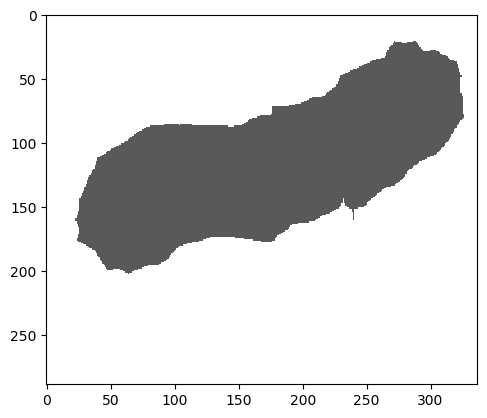

In [38]:
import PIL
from PIL import Image
import numpy as np
import io

num_classes = 21
mask = np.array(Image.open(io.BytesIO(response)))
plt.imshow(mask, vmin=0, vmax=num_classes-1, cmap='gray_r')
plt.show()

In [39]:
seg_predictor.delete_endpoint()